## Persiapan Awal

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from torchmetrics.classification import MulticlassPrecision, MulticlassRecall, MulticlassF1Score, MulticlassAccuracy, MulticlassConfusionMatrix
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms, models
import numpy as np
import kagglehub
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

c:\Users\justi\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
Device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(Device)

cuda


In [3]:
path = kagglehub.dataset_download("sumn2u/garbage-classification-v2")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\justi\.cache\kagglehub\datasets\sumn2u\garbage-classification-v2\versions\8


In [4]:
MainFolderPath = os.listdir(path)
MainFolder = os.path.join(path, MainFolderPath[0])

## Data Preprocessing

In [5]:
ValidationSize = 0.15
TestSize = 0.15
Seed      = 42
ImageSize = 224
Mean = [0.485, 0.456, 0.406]
StandardDeviation  = [0.229, 0.224, 0.225]
TotalWorkers = 4
BatchSize = 32

In [6]:
TransformTrain = transforms.Compose([
    transforms.RandomResizedCrop(ImageSize, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.15, 0.15, 0.15, 0.15),
    transforms.RandAugment(num_ops=2, magnitude=7),
    transforms.ToTensor(),
    transforms.RandomErasing(),
    transforms.Normalize(Mean, StandardDeviation),
])

TransformVal = transforms.Compose([
    transforms.Resize((ImageSize, ImageSize)),
    transforms.ToTensor(),
    transforms.Normalize(Mean, StandardDeviation),
])

TransformTest = transforms.Compose([
    transforms.Resize((ImageSize, ImageSize)),
    transforms.ToTensor(),
    transforms.Normalize(Mean, StandardDeviation)
])

In [7]:
FullDataset = datasets.ImageFolder(MainFolder)
IndexArray = np.arange(len(FullDataset))
Labels  = np.array(FullDataset.targets)

Xtrain, Xval, Ytrain, Yval = train_test_split(
    IndexArray,
    Labels,
    test_size = (ValidationSize + TestSize),
    stratify = Labels,
    random_state = Seed
)

Xval, Xtest, Yval, Ytest = train_test_split(
    Xval,
    Yval,
    test_size = (TestSize / (ValidationSize + TestSize)),
    stratify = Yval,
    random_state = Seed
)

In [8]:
ClassCount  = len(os.listdir(MainFolder))
TrainLabels = Labels[Xtrain]
ClassImageCount  = np.bincount(TrainLabels, minlength = ClassCount)
ClassImageWeights = 1.0 / np.maximum(ClassImageCount, 1)   
TrainSampleWeights = ClassImageWeights[TrainLabels]    

sampler = WeightedRandomSampler(
    weights = torch.as_tensor(TrainSampleWeights, dtype=torch.float),
    num_samples = len(TrainSampleWeights),
    replacement = True
)

In [9]:
FolderTrain = datasets.ImageFolder(MainFolder, transform=TransformTrain)
FolderValidation = datasets.ImageFolder(MainFolder, transform=TransformVal)
FolderTest = datasets.ImageFolder(MainFolder, transform=TransformTest)

TrainSet = Subset(FolderTrain, Xtrain)
ValidationSet = Subset(FolderValidation, Xval)
TestSet = Subset(FolderTest, Xtest)

TrainData = DataLoader(TrainSet, batch_size=BatchSize, sampler = sampler, num_workers=TotalWorkers, pin_memory=True)
ValidationData = DataLoader(ValidationSet, batch_size=BatchSize, shuffle=False, num_workers=TotalWorkers, pin_memory=True)
TestData = DataLoader(TestSet, batch_size=BatchSize, shuffle=False, num_workers=TotalWorkers, pin_memory=True)

## Modeling

In [10]:
WeightDecayBackbone = 3e-5
WeightDecayHead = 3e-4
LearningRateBackbone = 5e-5
LearningRateHead = 5e-4
b1 = 0.9
b2 = 0.999
epsilon = 1e-8
Epochs = 50
WarmupEpochs = Epochs * 0.1
Patience = 10

In [11]:
def ModelBuilder(evaluation):
    Weights = models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1
    Model = models.convnext_tiny(weights = (None if evaluation else Weights))
    Model.classifier[2] = nn.Linear(Model.classifier[2].in_features, ClassCount)

    return Model

In [12]:
model = ModelBuilder(False).to(Device)

In [13]:
def FreezeAll(model):

    for ParameterName, ModelParameter in model.named_parameters():
        ModelParameter.requires_grad = False

def UnfreezeHead(model):

    for ModelParameter in model.classifier[2].parameters():
        ModelParameter.requires_grad = True

def UnfreezeBackbone(model, stages):

    for i in stages:
        for ModelParameter in model.features[i].parameters():
            ModelParameter.requires_grad = True

In [14]:
FreezeAll(model)

UnfreezeHead(model)

UnfreezeBackbone(model, [5, 7])

In [15]:
BackboneParameters = []
HeadParameters = []

for ParameterName, ModelParameter in model.named_parameters():

    if not ModelParameter.requires_grad:
        continue
    
    if ParameterName.startswith("fc."):
        HeadParameters.append(ModelParameter)
    else:
        BackboneParameters.append(ModelParameter)

In [16]:
GoesToTrainStructure = []

if BackboneParameters:
    
    GoesToTrainStructure.append({

        "params": BackboneParameters, 
        "lr": LearningRateBackbone, 
        "weight_decay": WeightDecayBackbone
        
        })

if HeadParameters:

    GoesToTrainStructure.append({

        "params": HeadParameters,     
        "lr": LearningRateHead,
        "weight_decay": WeightDecayHead
        
        })

In [17]:
Optimizer = torch.optim.AdamW(GoesToTrainStructure, betas = (b1, b2), eps = epsilon)

WarmUp = torch.optim.lr_scheduler.LinearLR(Optimizer, start_factor=0.2, total_iters = WarmupEpochs)

CosineAnnealing = torch.optim.lr_scheduler.CosineAnnealingLR(Optimizer, T_max = Epochs - WarmupEpochs)

scheduler = torch.optim.lr_scheduler.SequentialLR(Optimizer, schedulers=[WarmUp, CosineAnnealing], milestones=[WarmupEpochs])

LossFunction = nn.CrossEntropyLoss(label_smoothing = 0.05)

## Training dan Evaluasi

In [18]:
def CalculateAccuracy(PredictedValues, ActualValues) :
    Predictions = torch.argmax(PredictedValues, dim = 1)
    NumberOfCorrectGuesses = (Predictions == ActualValues).sum().item()
    Accuracy = NumberOfCorrectGuesses / (ActualValues.numel())
    return Accuracy

def TrainingAndValidationProcess(Model, Dataset, Optimizer, LossFunction, Device, Train) :
    
    Model.train(Train)

    TrackLoss = 0.0
    TrackAccuracy = 0.0
    SamplesCount = 0

    ProgressBar = tqdm(Dataset, leave = False, desc = "train" if Train else "valid") 

    ToggleGradientCalculation = torch.enable_grad() if Train else torch.no_grad()
    
    with ToggleGradientCalculation:

        for image, labels in ProgressBar :
            image, labels = image.to(Device), labels.to(Device)

            if Train :
                Optimizer.zero_grad(set_to_none = True)

            PredictedValue = Model(image)
            Loss = LossFunction(PredictedValue, labels)

            if Train :
                Loss.backward()
                Optimizer.step()

            CurrentBatchSize = labels.size(0) 
            SamplesCount += CurrentBatchSize
            TrackLoss += Loss.item() * CurrentBatchSize
            TrackAccuracy += CalculateAccuracy(PredictedValue, labels) * CurrentBatchSize

            ProgressBar.set_postfix(loss = TrackLoss / SamplesCount, acc = TrackAccuracy / SamplesCount)

    TrueLoss = TrackLoss / SamplesCount
    TrueAccuracy = TrackAccuracy / SamplesCount

    return TrueLoss, TrueAccuracy

In [19]:
PerformanceTracker = {

                "TrainingLoss": [], 
                "TrainingAccuracy": [], 
                "ValidationLoss": [], 
                "ValidationAccuracy": []
            
                }

def ModelTrainAndValidation(ModelName, model, Optimizer, scheduler):

    BestValidationLoss = float("inf")
    PathForBestPerformanceCheckpointer = f"Model Weight/{ModelName}.pt"
    bad = 0

    for epoch in range(1, Epochs+1) :
        TrainingLoss, TrainingAccuracy = TrainingAndValidationProcess(model, TrainData, Optimizer, LossFunction, Device, True)
        ValidationLoss, ValidationAccuracy = TrainingAndValidationProcess(model, ValidationData, Optimizer, LossFunction, Device, False)

        PerformanceTracker["TrainingLoss"].append(TrainingLoss)
        PerformanceTracker["TrainingAccuracy"].append(TrainingAccuracy)
        PerformanceTracker["ValidationLoss"].append(ValidationLoss)
        PerformanceTracker["ValidationAccuracy"].append(ValidationAccuracy)

        print(f"[Epoch {epoch:02d}/{Epochs}] "
                  f"Train Loss = {TrainingLoss:.4f} | Train Accuracy = {TrainingAccuracy:.4f} || "
                  f"Validation Loss ={ValidationLoss:.4f} | Validation Accuracy ={ValidationAccuracy:.4f}")

        if ValidationLoss < (BestValidationLoss - (1e-6)):
            BestValidationLoss = ValidationLoss
            bad = 0
            torch.save(model.state_dict(), PathForBestPerformanceCheckpointer)
        else:
            bad += 1
            if bad >= Patience:
                print(f"Early stop at epoch {epoch} (no val loss improvement for {Patience} epochs).")
                break

        scheduler.step()    

In [20]:
def ModelTesting(BestModelPath):    

    model = ModelBuilder(True)
    state = torch.load(BestModelPath, map_location = Device)
    model.load_state_dict(state)
    model.to(Device).eval()

    precision = MulticlassPrecision(num_classes=ClassCount, average="macro").to(Device)
    recall    = MulticlassRecall(num_classes=ClassCount, average="macro").to(Device)
    f1        = MulticlassF1Score(num_classes=ClassCount, average="macro").to(Device)
    accuracy  = MulticlassAccuracy(num_classes=ClassCount, average="macro").to(Device) 
    cm        = MulticlassConfusionMatrix(num_classes=ClassCount).to(Device)

    for m in (precision, recall, f1, accuracy, cm):
        m.reset()

    with torch.inference_mode():
        for images, labels in TestData:
            images, labels = images.to(Device), labels.to(Device)
            logits = model(images)
            preds  = torch.argmax(logits, dim = 1)

            preds  = preds.to(torch.long)
            labels = labels.to(torch.long)

            precision.update(preds, labels)
            recall.update(preds, labels)
            f1.update(preds, labels)
            accuracy.update(preds, labels)
            cm.update(preds, labels)

    print("Accuracy  (macro):", accuracy.compute().item())
    print("Precision (macro):", precision.compute().item())
    print("Recall    (macro):", recall.compute().item())
    print("F1        (macro):", f1.compute().item())
    
    ConfusionMatrix = cm.compute().cpu().numpy()
    print("Confusion matrix:\n", ConfusionMatrix)

In [21]:
def Diagram():

    epochs = range(1, len(PerformanceTracker["TrainingLoss"])+1)

    # ======== Diagram Loss ========

    plt.figure(figsize=(10,4))

    plt.plot(epochs, PerformanceTracker["TrainingLoss"], label = "Training Loss")
    plt.plot(epochs, PerformanceTracker["ValidationLoss"], label = "Validation Loss")
    
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    plt.title("Training vs Validation Loss")
    plt.legend()
    
    plt.grid(True)
    plt.show()
    
    # ======== Diagram Akurasi ========
    
    plt.figure(figsize=(10,4))
    
    plt.plot(epochs, PerformanceTracker["TrainingAccuracy"], label="Training Acc")
    plt.plot(epochs, PerformanceTracker["ValidationAccuracy"], label="Validation Acc")
    
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    
    plt.grid(True)
    plt.show()

In [22]:
ModelTrainAndValidation("Best ConvNeXt", model, Optimizer, scheduler)

[Epoch 01/50] Train Loss = 1.5351 | Train Accuracy = 0.6212 || Validation Loss =0.7560 | Validation Accuracy =0.9072


[Epoch 02/50] Train Loss = 0.6346 | Train Accuracy = 0.8976 || Validation Loss =0.4382 | Validation Accuracy =0.9555


[Epoch 03/50] Train Loss = 0.4804 | Train Accuracy = 0.9376 || Validation Loss =0.3993 | Validation Accuracy =0.9639


[Epoch 04/50] Train Loss = 0.4247 | Train Accuracy = 0.9552 || Validation Loss =0.3751 | Validation Accuracy =0.9713


c:\Users\justi\anaconda3\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[Epoch 05/50] Train Loss = 0.3899 | Train Accuracy = 0.9665 || Validation Loss =0.3616 | Validation Accuracy =0.9747


[Epoch 06/50] Train Loss = 0.3678 | Train Accuracy = 0.9730 || Validation Loss =0.3638 | Validation Accuracy =0.9737


[Epoch 07/50] Train Loss = 0.3533 | Train Accuracy = 0.9772 || Validation Loss =0.3556 | Validation Accuracy =0.9781


[Epoch 08/50] Train Loss = 0.3433 | Train Accuracy = 0.9809 || Validation Loss =0.3516 | Validation Accuracy =0.9791


[Epoch 09/50] Train Loss = 0.3346 | Train Accuracy = 0.9831 || Validation Loss =0.3508 | Validation Accuracy =0.9801


[Epoch 10/50] Train Loss = 0.3322 | Train Accuracy = 0.9837 || Validation Loss =0.3540 | Validation Accuracy =0.9771


[Epoch 11/50] Train Loss = 0.3267 | Train Accuracy = 0.9857 || Validation Loss =0.3491 | Validation Accuracy =0.9808


[Epoch 12/50] Train Loss = 0.3233 | Train Accuracy = 0.9868 || Validation Loss =0.3634 | Validation Accuracy =0.9730


[Epoch 13/50] Train Loss = 0.3145 | Train Accuracy = 0.9908 || Validation Loss =0.3519 | Validation Accuracy =0.9791


[Epoch 14/50] Train Loss = 0.3171 | Train Accuracy = 0.9890 || Validation Loss =0.3487 | Validation Accuracy =0.9784


[Epoch 15/50] Train Loss = 0.3121 | Train Accuracy = 0.9905 || Validation Loss =0.3512 | Validation Accuracy =0.9777


[Epoch 16/50] Train Loss = 0.3163 | Train Accuracy = 0.9887 || Validation Loss =0.3492 | Validation Accuracy =0.9784


[Epoch 17/50] Train Loss = 0.3156 | Train Accuracy = 0.9897 || Validation Loss =0.3541 | Validation Accuracy =0.9781


[Epoch 18/50] Train Loss = 0.3092 | Train Accuracy = 0.9912 || Validation Loss =0.3478 | Validation Accuracy =0.9821


[Epoch 19/50] Train Loss = 0.3077 | Train Accuracy = 0.9923 || Validation Loss =0.3506 | Validation Accuracy =0.9787


[Epoch 20/50] Train Loss = 0.3089 | Train Accuracy = 0.9916 || Validation Loss =0.3524 | Validation Accuracy =0.9794


[Epoch 21/50] Train Loss = 0.3053 | Train Accuracy = 0.9928 || Validation Loss =0.3580 | Validation Accuracy =0.9784


[Epoch 22/50] Train Loss = 0.3037 | Train Accuracy = 0.9938 || Validation Loss =0.3496 | Validation Accuracy =0.9814


[Epoch 23/50] Train Loss = 0.3000 | Train Accuracy = 0.9945 || Validation Loss =0.3491 | Validation Accuracy =0.9791


[Epoch 24/50] Train Loss = 0.3024 | Train Accuracy = 0.9931 || Validation Loss =0.3484 | Validation Accuracy =0.9798


[Epoch 25/50] Train Loss = 0.2990 | Train Accuracy = 0.9947 || Validation Loss =0.3550 | Validation Accuracy =0.9777


[Epoch 26/50] Train Loss = 0.2988 | Train Accuracy = 0.9947 || Validation Loss =0.3569 | Validation Accuracy =0.9787


[Epoch 27/50] Train Loss = 0.3048 | Train Accuracy = 0.9928 || Validation Loss =0.3500 | Validation Accuracy =0.9787


[Epoch 28/50] Train Loss = 0.2983 | Train Accuracy = 0.9954 || Validation Loss =0.3476 | Validation Accuracy =0.9811


[Epoch 29/50] Train Loss = 0.2976 | Train Accuracy = 0.9949 || Validation Loss =0.3558 | Validation Accuracy =0.9798


[Epoch 30/50] Train Loss = 0.2967 | Train Accuracy = 0.9960 || Validation Loss =0.3457 | Validation Accuracy =0.9814


[Epoch 31/50] Train Loss = 0.2972 | Train Accuracy = 0.9952 || Validation Loss =0.3449 | Validation Accuracy =0.9814


[Epoch 32/50] Train Loss = 0.2943 | Train Accuracy = 0.9969 || Validation Loss =0.3521 | Validation Accuracy =0.9814


[Epoch 33/50] Train Loss = 0.2971 | Train Accuracy = 0.9954 || Validation Loss =0.3504 | Validation Accuracy =0.9811


[Epoch 34/50] Train Loss = 0.2941 | Train Accuracy = 0.9962 || Validation Loss =0.3492 | Validation Accuracy =0.9811


[Epoch 35/50] Train Loss = 0.2958 | Train Accuracy = 0.9963 || Validation Loss =0.3495 | Validation Accuracy =0.9791


[Epoch 36/50] Train Loss = 0.2952 | Train Accuracy = 0.9961 || Validation Loss =0.3451 | Validation Accuracy =0.9818


[Epoch 37/50] Train Loss = 0.2924 | Train Accuracy = 0.9972 || Validation Loss =0.3469 | Validation Accuracy =0.9821


[Epoch 38/50] Train Loss = 0.2933 | Train Accuracy = 0.9967 || Validation Loss =0.3444 | Validation Accuracy =0.9828


[Epoch 39/50] Train Loss = 0.2924 | Train Accuracy = 0.9970 || Validation Loss =0.3507 | Validation Accuracy =0.9804


[Epoch 40/50] Train Loss = 0.2926 | Train Accuracy = 0.9969 || Validation Loss =0.3445 | Validation Accuracy =0.9821


[Epoch 41/50] Train Loss = 0.2933 | Train Accuracy = 0.9972 || Validation Loss =0.3434 | Validation Accuracy =0.9825


[Epoch 42/50] Train Loss = 0.2930 | Train Accuracy = 0.9972 || Validation Loss =0.3463 | Validation Accuracy =0.9811


[Epoch 43/50] Train Loss = 0.2933 | Train Accuracy = 0.9965 || Validation Loss =0.3454 | Validation Accuracy =0.9814


[Epoch 44/50] Train Loss = 0.2922 | Train Accuracy = 0.9973 || Validation Loss =0.3449 | Validation Accuracy =0.9821


[Epoch 45/50] Train Loss = 0.2929 | Train Accuracy = 0.9970 || Validation Loss =0.3446 | Validation Accuracy =0.9825


[Epoch 46/50] Train Loss = 0.2907 | Train Accuracy = 0.9978 || Validation Loss =0.3443 | Validation Accuracy =0.9831


[Epoch 47/50] Train Loss = 0.2908 | Train Accuracy = 0.9975 || Validation Loss =0.3447 | Validation Accuracy =0.9825


[Epoch 48/50] Train Loss = 0.2905 | Train Accuracy = 0.9978 || Validation Loss =0.3447 | Validation Accuracy =0.9825


[Epoch 49/50] Train Loss = 0.2928 | Train Accuracy = 0.9971 || Validation Loss =0.3448 | Validation Accuracy =0.9825


[Epoch 50/50] Train Loss = 0.2912 | Train Accuracy = 0.9976 || Validation Loss =0.3448 | Validation Accuracy =0.9825


In [23]:
ModelTesting("Model Weight/Best ConvNeXt.pt")

Accuracy  (macro): 0.9762377738952637
Precision (macro): 0.975321888923645
Recall    (macro): 0.9762377738952637
F1        (macro): 0.9757125973701477
Confusion matrix:
 [[140   0   0   0   0   0   0   0   0   1]
 [  0 148   0   0   0   0   0   0   1   0]
 [  0   1 270   0   0   0   3   0   0   0]
 [  0   0   0 791   0   0   0   0   7   1]
 [  0   0   1   0 455   2   0   2   0   0]
 [  1   0   0   0   3 147   0   2   0   0]
 [  0   0   2   3   1   0 237   1   0   8]
 [  0   1   0   1   4   1   0 289   0   2]
 [  0   0   0   2   0   0   1   0 294   0]
 [  0   0   1   0   0   1   3   2   0 135]]


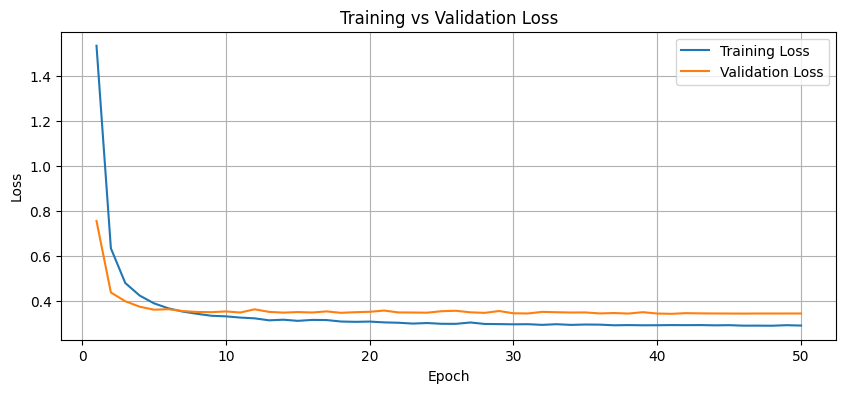

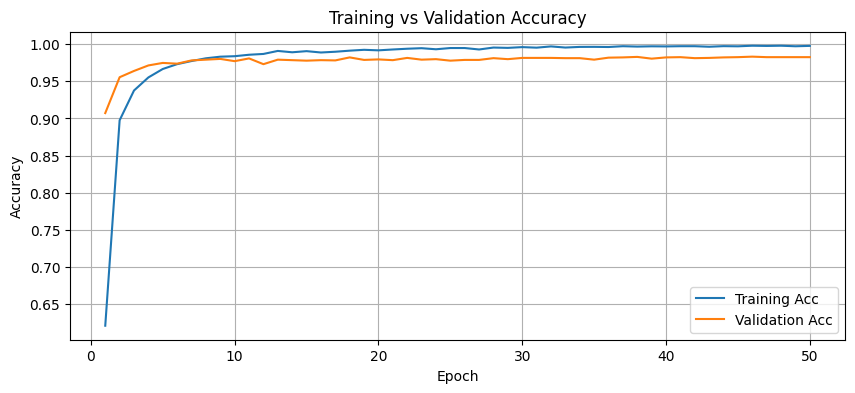

In [24]:
Diagram()